Progress:
currently able to produce submissions, but the score(2.8463) sucks lol 

Further Improvements:
1. the nodes are set to 7, should check if other number of nodes work. Then include all the node # combination
2. adjust randomizer to only generate mechanism with initial state within the d/m constraint
3. optimize the GA/GD parameters: step_size, n_steps, popuation, generation


In [18]:
import os
os.environ["JAX_PLATFORMS"] = "cpu"  # Disable GPU for JAX (Remove if you want to use GPU)

import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm.auto import tqdm, trange

# deteministic random numbers
np.random.seed(0)
random.seed(0)

In [19]:
%%capture
!git clone https://github.com/ahnobari/2155-Optimization-Challenge-Problem.git
!mv ./2155-Optimization-Challenge-Problem/* .
!rm -rf ./2155-Optimization-Challenge-Problem
!pip install pymoo==0.6.1 svgpath2mpl

# Linkage Synthesis Challenge Problem Advanced Code
Here we will tackle the problem with a more complex GA approach. In this notebook, rather than just optimizing the node positions, we will also optimize the connectivity of the mechanims itself. First let's just load the target curves like we did before:


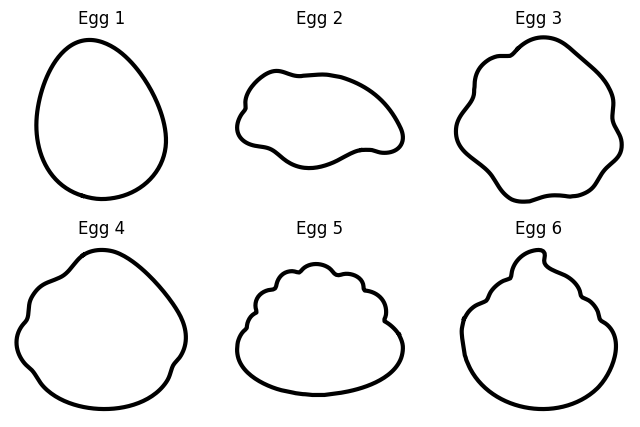

In [20]:
target_curves = np.load('target_curves.npy')

# Plot all target curves

# Initialize a 2x3 subplot for plotting all target curves
fig, axs = plt.subplots(2, 3, figsize=(8, 5))

# Loop through the 6 target curves to plot them
for i in range(6):
    # Extract x and y coordinates from the target curve
    x_coords = np.array(target_curves[i])[:, 0]
    y_coords = np.array(target_curves[i])[:, 1]

    # Plot the curve on the respective subplot
    axs[i // 3, i % 3].plot(x_coords, y_coords, color='black', linewidth=3)

    # Set title for each subplot
    axs[i // 3, i % 3].set_title(f'Egg {i + 1}')

    # Ensure equal scaling for x and y axes
    axs[i // 3, i % 3].axis('equal')
    axs[i // 3, i % 3].axis('off')


## GA Full Mechanism Generation
To set up the problem within Pymoo we will have to come up with a 1D representation of the mechanisms. This code effectively just flattens the matrices and variables describing our mechanism into a single vector. However, this representation scheme is highly suboptimal, and can be improved significantly. As a demonstration, we will slightly improve upon this representation, though we encourage you to take this further. As we discussed, we can replace the edges with a connectivity matrrix. We also know the connectivity matrix is symmetric (if nodes 1 and 2 are connected nodes 2 and 1 are also connected) and has a diagonal equal to zero. To avoid making the optimization come up with the whole connectivity matrix, we will only have it come up with the upper triangular half of the matrix (not including the diagonal). This means the algorithm has to come up with $\frac{N^2-N}{2}$ 0s or 1s (i.e., booleans) to construct the adjacency matrix. We can further simplify the process by selecting a fixed motor position and having the optimization build the rest of the mechanism, removing the need for the optimization to determine the motor as well as reducing the number of 0s and 1s in the upper triangular portion by one (Saving 3 parameters in the representation). To do this we will start with the following mechanism:

<img src="https://i.ibb.co/mGywWgr/start.jpg" alt="start" border="0">

We set Node 0 to ground and Node 1 to be ordinary and the motor to be `[1,0]`. Now we know that the upper triangular portion of the connectivity matrix starts with:

<img src="https://i.ibb.co/5RqKYQN/upper-triangular-fromstart.jpg" alt="upper-triangular-fromstart" border="0">

Since we know the types of the first two nodes, we save another two parameters from the optimization. At this point we will have the same representation as we have before, but with fewer numbers and no motor or N (size of mechanisms) as we generate the mechanism to have a certain size.

<img src="https://i.ibb.co/gv2D0Y5/Optimization-Represenation.png" alt="Optimization-Represenation" border="0">

Now that we have a (slightly) improved 1D representation scheme, we will set up our problem with this many parameters. We also need to specify our constraints! Inequality constraints can be set in Pymoo (See: [constraints in pymoo](https://www.pymoo.org/constraints/index.html)) as less than or equal to zero constraints. We will set the two constraints on distance and material use in our problem.

So based on this lets get started with defining the problem in Pymoo.
<ul>
    <li>
        <code>__init__</code>: We need to differentiate between datatypes because crossover, sampling, and mutation will happen slightly differently based on datatype. As such, we create a dictionary of variables and specify which type of variable each one is.
    </li>
    <li>
<code>convert_1D_to_mech</code>: Reformats our dictionary of variables into design info that our simulator uses (edges, x0, etc.). You will need to update this function if you change the way you parameterize mechanisms. IMPORTANT: This function should not be confused for the. We have also provided a function, <code> convert_mech_to_1D </code> to do the opposite, which you may find useful. It is currently unused and is commented out.
    </li>
    <li>
<code>_evaluate</code>: Next, we define the evaluation function. We construct the mechanism using <code>convert_1D_to_mech</code>. Next, perform the same evaluations as we did in the starter notebook.
    </li>
</ul>

In [21]:
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.variable import Real, Integer, Choice, Binary
from pymoo.core.mixed import MixedVariableMating, MixedVariableGA, MixedVariableSampling, MixedVariableDuplicateElimination
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import FloatRandomSampling, Sampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.optimize import minimize

from LINKS.Optimization import DifferentiableTools, Tools

In [22]:
PROBLEM_TOOLS = Tools( # we have to define this outside the class due to pymoo deepcopy limitations
            device='cpu' # device to run the optimization on
        )
PROBLEM_TOOLS.compile() # compile the functions for faster runs

class mechanism_synthesis_optimization(ElementwiseProblem):

    # When intializing, set the mechanism size and target curve
    def __init__(self, target_curve, N = 5):
        self.N = N
        variables = dict()

        # The upper triangular portion of our NxN Connectivity Matrix consists of Nx(N-1)/2 boolean variables:
        for i in range(N):
            for j in range(i):
                variables["C" + str(j) + "_" + str(i)] = Binary()

        # We Delete C0_1 since we know node 1 is connected to the motor
        del variables["C0_1"]

        #Our position matrix consists of Nx2 real numbers (cartesian coordinate values) between 0 and 1
        for i in range(2*N):
            variables["X0" + str(i)] = Real(bounds=(0.0, 1.0))

        # Our node type vector consists of N boolean variables (fixed vs non-fixed)
        for i in range(N):
            variables["fixed_nodes" + str(i)] =  Binary(N)

        # Our target node is an integer between 1 and N-1, (any except the motor node).
        variables["target"] = Integer(bounds=(1,N-1))

        # Set up some variables in the problem class we inherit for pymoo
        # n_obj=number of objectives, n_constr=number of constraints
        # Our objectives are chamfer distance and material, and they both have constraints.
        super().__init__(vars=variables, n_obj=2, n_constr=2)

        # Store the target curve point cloud
        self.target_curve = target_curve


    def convert_1D_to_mech(self, x):
        N = self.N

        # Get target joints index
        target_idx = x["target"]

        # Build connectivity matrix from its flattened constitutive variables
        C = np.zeros((N,N))
        x["C0_1"] = 1

        for i in range(N):
            for j in range(i):
                # C[i,j] = x["C" + str(j) + "_" + str(i)]
                C[j,i] = x["C" + str(j) + "_" + str(i)]

        edges = np.array(np.where(C==1)).T

        # Reshape flattened position matrix to its proper Nx2 shape
        x0 = np.array([x["X0" + str(i)] for i in range(2*N)]).reshape([N,2])

        # Extract a list of Nodes that are fixed from boolean fixed_nodes vector
        fixed_joints = np.where(np.array([x["fixed_nodes" + str(i)] for i in range(N)]))[0].astype(int)

        #We fix the motor and original ground node as 0 and 1 respectively in this implementation
        motor=np.array([0,1])

        return x0, edges, fixed_joints, motor, target_idx

    def convert_mech_to_1D(self, x0, edges, fixed_joints, target_idx=None, **kwargs):
        # This function assumes motor to be [0, 1] our random mechanism generator automatically does this
        N = self.N

        # Initialize dictionary to store 1D representation of mechanism
        x = {}

        # Store target node value
        if target_idx is None:
            target_idx = x0.shape[0]-1 # Assume last node is the target if not specified

        x["target"] = target_idx

        # Store connectivity matrix in its flattened form
        C = np.zeros((N,N), dtype=bool)
        C[edges[:,0], edges[:,1]] = 1
        C[edges[:,1], edges[:,0]] = 1

        for i in range(N):
            for j in range(i):
                x["C" + str(j) + "_" + str(i)] = C[i,j]

        del x["C0_1"]

        # Store position matrix in its flattened form
        if x0.shape[0] != N:
            x0 = np.pad(x0, ((0, N - x0.shape[0]), (0, 0)), 'constant', constant_values=0)

        for i in range(2*N):
            x["X0" + str(i)] = x0.flatten()[i]

        # Store fixed nodes in boolean vector form
        for i in range(N):
            x["fixed_nodes" + str(i)] = (i in fixed_joints) or (i>=N)

        return x

    def _evaluate(self, x, out, *args, **kwargs):
        #Convert to mechanism representation
        x0, edges, fixed_joints, motor, target_idx = self.convert_1D_to_mech(x)

        # Simulate
        distance, material = PROBLEM_TOOLS(x0,
                                edges,
                                fixed_joints,
                                motor,
                                self.target_curve,
                                target_idx=target_idx
                            )

        out["F"] = np.array([distance, material])
        out["G"] = out["F"] - np.array([0.75, 10.0])  # Constraints: distance <= 0.75, material <= 10.0


In [23]:
from LINKS.Optimization import MechanismRandomizer
from LINKS.Visualization import MechanismVisualizer

In [24]:
randomizer = MechanismRandomizer(
    min_size = 6, # smalllest mechanism to sample
    max_size = 14, # largest mechanism to sample
    device='cpu')

visualizer = MechanismVisualizer()

In [25]:
# Now let's generate 100 mechanisms of size 7 and initilize a population for optimization
mechanisms = [randomizer(n=7) for _ in trange(100)]

  0%|          | 0/100 [00:00<?, ?it/s]

In [26]:
problem = mechanism_synthesis_optimization(target_curves[3], N=7)

initial_population = [problem.convert_mech_to_1D(**mech) for mech in mechanisms]

class sample_from_random(Sampling):
        def _do(self, problem, n_samples, **kwargs):
                return np.array([initial_population[i%len(initial_population)] for i in range(n_samples)])

F = problem.evaluate(np.array(initial_population))[0]
print(f'Best Distance Performance In random population: {F[:,0].min()}')
print(f'Best Material Performance In random population: {F[:,1].min()}')

# print(F)  # Should be (100, 2)
# num_fisible = 0
# for f in range(F.shape[0]):
#         if F[f,0]<0.75 and F[f,1]<10:
#                 num_fisible+=1

# print(f'Number of feasible mechanisms in initial population: {num_fisible} out of {len(F)}')

Best Distance Performance In random population: 1.115274429321289
Best Material Performance In random population: 5.041465759277344


In [27]:
algorithm = NSGA2(pop_size=100,
                  sampling=sample_from_random(),
                  mating=MixedVariableMating(eliminate_duplicates=MixedVariableDuplicateElimination()),
                  mutation=PolynomialMutation(prob=0.5),
                  eliminate_duplicates=MixedVariableDuplicateElimination())

results = minimize(problem,
                algorithm,
                ('n_gen', 100),
                verbose=True,
                save_history=True,
                seed=0
                )

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      1 |  0.4580439329 |  9.3528617382 |             - |             -
     2 |      200 |      1 |  0.4580439329 |  8.3571057940 |             - |             -
     3 |      300 |      1 |  0.4580439329 |  8.1509425449 |             - |             -
     4 |      400 |      1 |  0.4580439329 |  7.3328393841 |             - |             -
     5 |      500 |      1 |  0.4580439329 |  6.8712682581 |             - |             -
     6 |      600 |      1 |  0.4580439329 |  6.5101742005 |             - |             -
     7 |      700 |      1 |  0.0818068385 |  5.8478052276 |             - |             -
     8 |      800 |      1 |  0.0818068385 |  5.4998779052 |             - |             -
     9 |      900 |      1 |  0.0818068385 |  4.5471280426 |             - |             -
    10 |     1000 |      1 |  0.0818068385 |  4.1585621113 |             - |             -

In [28]:
print(f"There are {results.F.shape[0]} non-dominated solutions found.")

There are 8 non-dominated solutions found.


We see that if we initialize GA with some valid samples, it is much more likely to succeed! Let's take a look at the solutions of this run:

In [29]:
from LINKS.Visualization import GAVisualizer
from LINKS.Kinematics import MechanismSolver
from LINKS.Geometry import CurveEngine

Hyper Volume ~ 3.660688


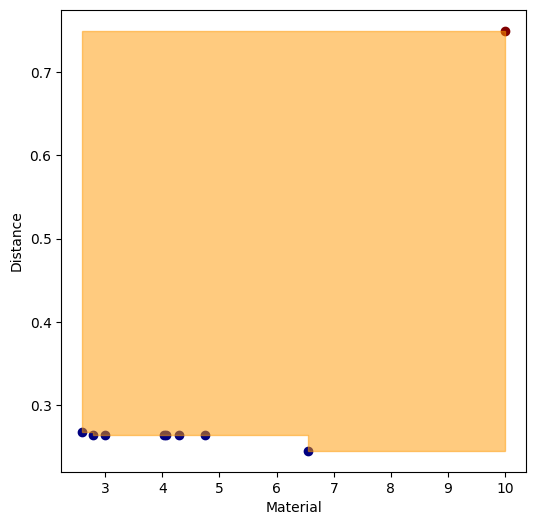

In [30]:
from pymoo.indicators.hv import HV
ga_visualizer = GAVisualizer()
solver = MechanismSolver(device='cpu')
curve_engine = CurveEngine(device='cpu')

if not results.X is None:
    #Specify reference point
    ref_point = np.array([0.75, 10.0])

    #Calculate Hypervolume
    ind = HV(ref_point)
    hypervolume = ind(results.F)

    #Print and plot
    print('Hyper Volume ~ %f' %(hypervolume))
    ga_visualizer.plot_HV(results.F, ref_point, objective_labels=['Distance', 'Material']) #use the plot_HV function from utils
else:
    print('Did Not Find Solutions!!')

## Apply Gradient-based opt to the results of GA

Now let's take the GA solutions from above and just optimize for the lowest distance. Then we will add the optimized solutions to the population we have and see how the hypervolume changes.

 **Note that if the material use exceeds 10 during this optimization the score will not change How could you address this?**

In [31]:
from LINKS.Optimization import DifferentiableTools

In [32]:
differentiable_optimization_tools = DifferentiableTools(
    device='cpu' # device to run the optimization on
)
differentiable_optimization_tools.compile() # compile the functions for faster runs

In [33]:
# lets make a batch from our GA results
x0s = []
edges = []
fixed_joints = []
motors = []
target_idxs = []
if not results.X is None:
    if not isinstance(results.X, dict):
        for i in range(results.X.shape[0]):
            x0_member, edges_member, fixed_joints_member, motor_member, target_idx_member  = problem.convert_1D_to_mech(results.X[i])
            x0s.append(x0_member)
            edges.append(edges_member)
            fixed_joints.append(fixed_joints_member)
            motors.append(motor_member)
            target_idxs.append(target_idx_member)
    else:
        x0_member, edges_member, fixed_joints_member, motor_member, target_idx_member  = problem.convert_1D_to_mech(results.X)
        x0s.append(x0_member)
        edges.append(edges_member)
        fixed_joints.append(fixed_joints_member)
        motors.append(motor_member)
        target_idxs.append(target_idx_member)

Hyper Volume ~ 3.660687


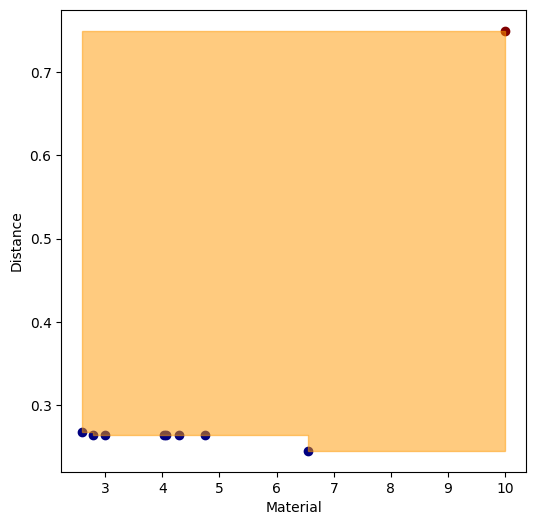

In [34]:
if not x0s is None:
    # Evaluate the mechanisms in x0s to get their objective values (Distance and Material)
    # Assuming edges, fixed_joints, motors, and target_idxs are aligned with x0s
    F_x0s = np.array(
        PROBLEM_TOOLS(
            x0s,
            edges, # Using the edges corresponding to x0s
            fixed_joints, # Using the fixed_joints corresponding to x0s
            motors, # Using the motors corresponding to x0s
            target_curves[3], # Assuming target curve 1 is still being used
            target_idxs # Using the target_idxs corresponding to x0s
        )
    ).T # Transpose to get shape (n_solutions, n_objectives)

    #Specify reference point
    ref_point = np.array([0.75, 10.0])

    #Calculate Hypervolume of the evaluated solutions
    ind = HV(ref_point)
    # Make sure F_x0s has at least one solution and two objectives
    if F_x0s.shape[0] > 0 and F_x0s.shape[1] == 2:
        hypervolume = ind(F_x0s)

        #Print and plot
        print('Hyper Volume ~ %f' %(hypervolume))
        ga_visualizer.plot_HV(F_x0s, ref_point, objective_labels=['Distance', 'Material']) # Plot using the evaluated objective values
    else:
        print("Could not calculate hypervolume or plot: F_x0s does not have the expected shape.")

else:
    print('Did Not Find Solutions!!')

here is how this differentiable class works:

In [35]:
distances, materials, distance_grads, material_grads = differentiable_optimization_tools(
    x0s,
    edges,
    fixed_joints,
    motors,
    target_curves[1],
    target_idxs
)

print(materials, distances)

[6.549348  2.600532  4.033616  4.2986813 4.055684  2.7858152 4.753914
 2.9877834] [1.4086204 1.5055453 1.501587  1.5016173 1.5015858 1.500922  1.5016336
 1.5026243]


**NOTE:** Sometimes the mechanisms are close to locking, which results in gradients exploding and in these cases the `DifferentiableTools` will return inifity results. You can ignore these since the `Tools` class will still simulate them eventhough the gradients are near singular.

### Gradient of the distance function and apply gradient descent

In [36]:
x_d = x0s.copy()

step_size = 4e-4
n_steps = 1000

# keep track of which members are done optimizing
done_optimizing = np.zeros(len(x_d), dtype=bool)

x_last = x_d.copy()

for step in trange(n_steps):

    # get current distances, materials and gradients
    distances, materials, distance_grads, material_grads = differentiable_optimization_tools(
        x_d,
        edges,
        fixed_joints,
        motors,
        target_curves[1],
        target_idxs
    )

    # only update members that are valid and not done optimizing
    valids = np.where(np.logical_and(distances <= 0.75, materials <= 10.0))[0]
    invalids = np.where(~np.logical_and(distances <= 0.75, materials <= 10.0))[0]

    # if a member is invalid, revert to last step and mark as done optimizing
    for i in invalids:
        done_optimizing[i] = True
        x_d[i] = x_last[i]

    # keep a copy of last step
    x_last = x_d.copy()

    # update valid members
    for i in valids:
        if done_optimizing[i]:
            continue
        x_d[i] = x_d[i] - step_size * distance_grads[i]

    if np.all(done_optimizing):
        print(f'All members are done optimizing at step {step}')
        break

  0%|          | 0/1000 [00:00<?, ?it/s]

All members are done optimizing at step 0


### Gradient of the material function and apply gradient descent

In [37]:
x_m = x0s.copy()

step_size = 4e-4
n_steps = 1000

# keep track of which members are done optimizing
done_optimizing = np.zeros(len(x_m), dtype=bool)

x_last = x_m.copy()

for step in trange(n_steps):

    # get current distances, materials and gradients
    distances, materials, distance_grads, material_grads = differentiable_optimization_tools(
        x_m,
        edges,
        fixed_joints,
        motors,
        target_curves[1],
        target_idxs
    )

    # only update members that are valid and not done optimizing
    valids = np.where(np.logical_and(distances <= 0.75, materials <= 10.0))[0]
    invalids = np.where(~np.logical_and(distances <= 0.75, materials <= 10.0))[0]

    # if a member is invalid, revert to last step and mark as done optimizing
    for i in invalids:
        done_optimizing[i] = True
        x_m[i] = x_last[i]

    # keep a copy of last step
    x_last = x_m.copy()

    # update valid members
    for i in valids:
        if done_optimizing[i]:
            continue
        x_m[i] = x_m[i] - step_size * material_grads[i]

    if np.all(done_optimizing):
        print(f'All members are done optimizing at step {step}')
        break

  0%|          | 0/1000 [00:00<?, ?it/s]

All members are done optimizing at step 0


Now we can combine these new memebers with the old and see how the hypervolume changes:

In [38]:
combined_x0s = x0s + x_d + x_m
combined_edges = edges + edges + edges
combined_fixed_joints = fixed_joints + fixed_joints + fixed_joints
combined_motors = motors + motors + motors
combined_target_idxs = target_idxs + target_idxs + target_idxs

F = np.array(
    PROBLEM_TOOLS(
        combined_x0s,
        combined_edges,
        combined_fixed_joints,
        combined_motors,
        target_curves[3],
        combined_target_idxs
    )).T

F_before = np.array(
    PROBLEM_TOOLS(
        x0s,
        edges,
        fixed_joints,
        motors,
        target_curves[3],
        target_idxs
    )).T

ref = np.array([0.75, 10.0])
ind = HV(ref)

hv_before = ind(F_before)
hv_after = ind(F)

print(f'Hypervolume before gradient optimization: {hv_before:.4f}, after optimization: {hv_after:.4f}')

Hypervolume before gradient optimization: 3.6607, after optimization: 3.6607


In [39]:
print(len(combined_x0s))

24


<Axes: title={'center': 'After Gradient Optimization'}, xlabel='Material', ylabel='Distance'>

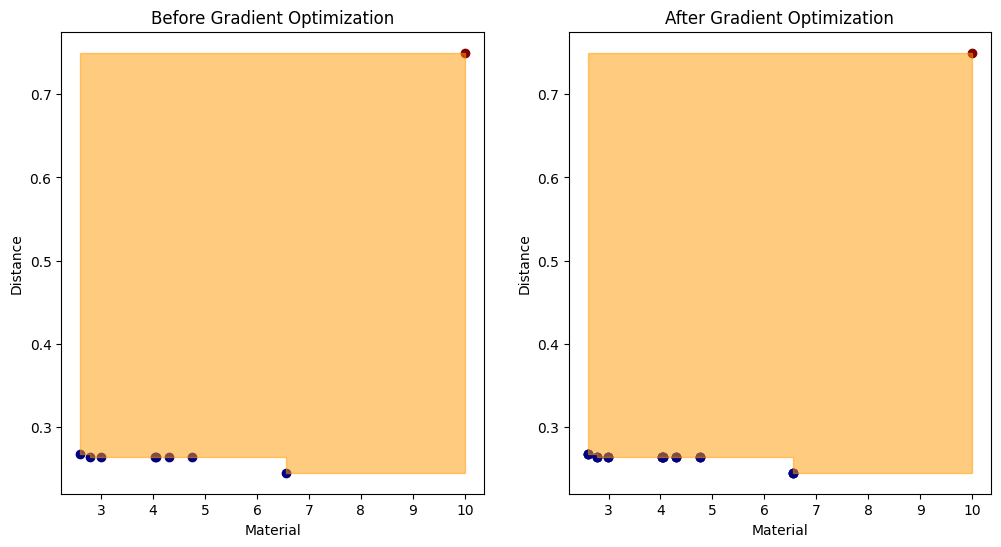

In [40]:
plt.subplots(1, 2, figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Before Gradient Optimization')
ga_visualizer.plot_HV(F_before, ref, objective_labels=['Distance', 'Material'], ax=plt.gca())

plt.subplot(1, 2, 2)
plt.title('After Gradient Optimization')
ga_visualizer.plot_HV(F, ref, objective_labels=['Distance', 'Material'], ax=plt.gca())

## Appy GA to the newly combined population

In [41]:
# Convert the combined mechanism components back to the 1D representation for Pymoo
combined_initial_population_1D = [
    problem.convert_mech_to_1D(
        x0=combined_x0s[i],
        edges=combined_edges[i],
        fixed_joints=combined_fixed_joints[i],
        motor=combined_motors[i],
        target_idx=combined_target_idxs[i]
    ) for i in range(len(combined_x0s))
]

# Define a custom Sampling class to use the combined initial population
class CombinedPopulationSampling(Sampling):
    def __init__(self, population):
        super().__init__()
        self.population = population

    def _do(self, problem, n_samples, **kwargs):
        # Return the predefined population
        # Ensure the returned population size matches n_samples if needed,
        # but for initialization we usually just return the whole population
        return self.population[:n_samples] # Return up to n_samples from the predefined population


# Now, initialize the NSGA2 algorithm using the combined population as the initial sampling
algorithm = NSGA2(pop_size=len(combined_initial_population_1D), # Set population size to the size of the combined population
                  sampling=CombinedPopulationSampling(combined_initial_population_1D), # Use the custom sampling class
                  mating=MixedVariableMating(eliminate_duplicates=MixedVariableDuplicateElimination()),
                  mutation=PolynomialMutation(prob=0.5),
                  eliminate_duplicates=MixedVariableDuplicateElimination())

results = minimize(problem,
                algorithm,
                ('n_gen', 100),
                verbose=True,
                save_history=True,
                seed=0
                )

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |        8 |      8 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |       32 |      9 |  0.000000E+00 |           INF |  0.0952171076 |         ideal
     3 |       56 |      9 |  0.000000E+00 |           INF |  0.000000E+00 |             f
     4 |       80 |      9 |  0.000000E+00 |           INF |  0.000000E+00 |             f
     5 |      104 |      9 |  0.000000E+00 |           INF |  0.000000E+00 |             f
     6 |      128 |      9 |  0.000000E+00 |           INF |  0.000000E+00 |             f
     7 |      152 |      9 |  0.000000E+00 |           INF |  0.000000E+00 |             f
     8 |      176 |      9 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     9 |      200 |      6 |  0.000000E+00 |  0.000000E+00 |  0.0058970876 |             f
    10 |      224 |      7 |  0.000000E+00 |  0.000000E+00 |  0.0048131683 |             f

In [42]:
print(f"There are {results.F.shape[0]} non-dominated solutions found.")

There are 8 non-dominated solutions found.


Hyper Volume ~ 4.424069


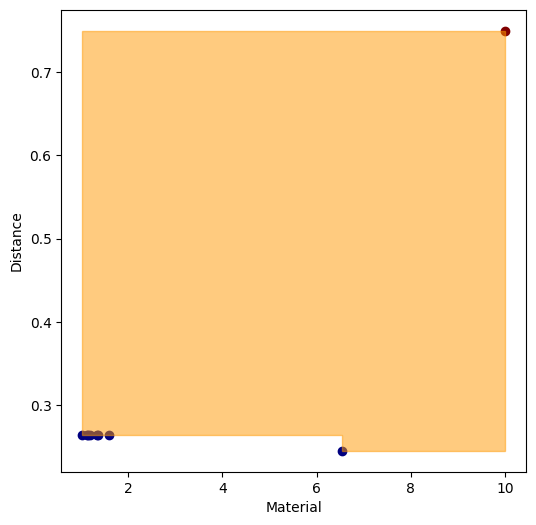

In [43]:
from pymoo.indicators.hv import HV
ga_visualizer = GAVisualizer()
solver = MechanismSolver(device='cpu')
curve_engine = CurveEngine(device='cpu')

if not results.X is None:
    #Specify reference point
    ref_point = np.array([0.75, 10.0])

    #Calculate Hypervolume
    ind = HV(ref_point)
    hypervolume = ind(results.F)

    #Print and plot
    print('Hyper Volume ~ %f' %(hypervolume))
    ga_visualizer.plot_HV(results.F, ref_point, objective_labels=['Distance', 'Material']) #use the plot_HV function from utils
else:
    print('Did Not Find Solutions!!')

## Visualize Result

Now Let's visualize the best solution for distance

In [44]:
if not results.X is None:
    if type(results.X)!=dict:
        best_idx = np.argmin(results.F[:,0])
        best_sol, edges, fixed_joints, motor, target_idx  = problem.convert_1D_to_mech(results.X[best_idx])
    else:
        best_sol, edges, fixed_joints, motor, target_idx  = problem.convert_1D_to_mech(results.X)
else:
    print('Did Not Find Solutions!!')

Distance: 0.2451, Material: 6.5493


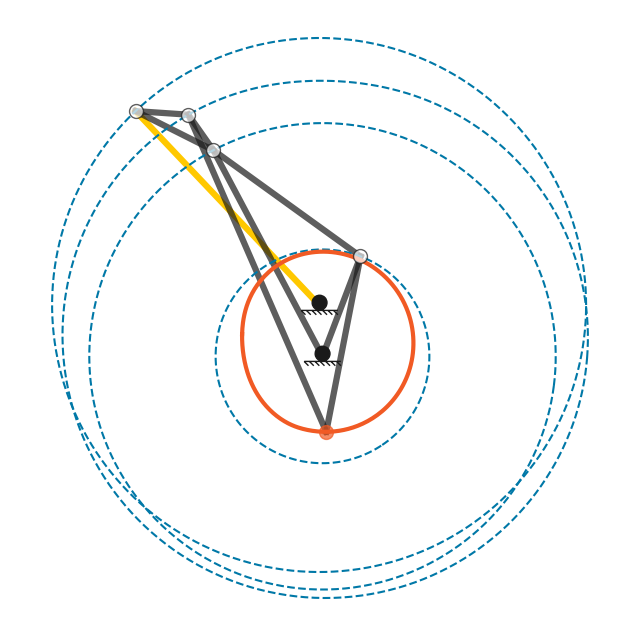

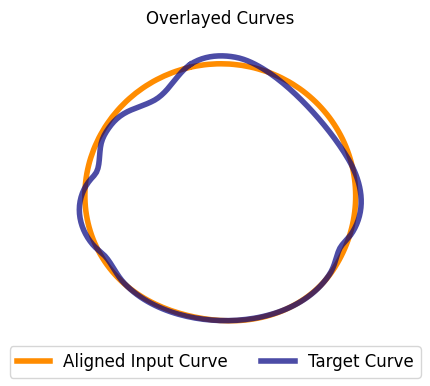

In [45]:
plt.figure(figsize=(8,8))
visualizer(best_sol, edges, fixed_joints, motor, highlight=target_idx, ax=plt.gca())

traced_curve = solver(best_sol, edges, fixed_joints, motor)[target_idx]
curve_engine.visualize_comparison(
    traced_curve,
    target_curves[3]
)

print(f'Distance: {results.F[best_idx,0]:.4f}, Material: {results.F[best_idx,1]:.4f}')

Now Let's visualize the best solution for material

In [46]:
if not results.X is None:
    if type(results.X)!=dict:
        best_idx = np.argmin(results.F[:,1])
        best_sol, edges, fixed_joints, motor, target_idx  = problem.convert_1D_to_mech(results.X[best_idx])
    else:
        best_sol, edges, fixed_joints, motor, target_idx  = problem.convert_1D_to_mech(results.X)
else:
    print('Did Not Find Solutions!!')

Distance: 0.2640, Material: 1.0321


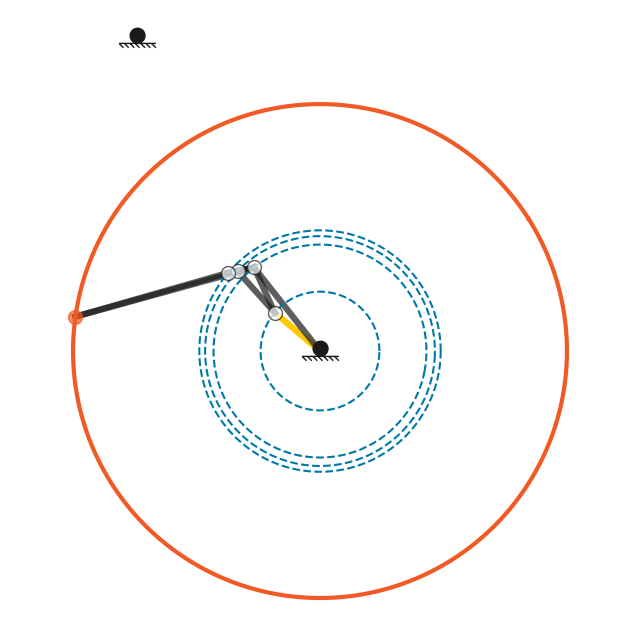

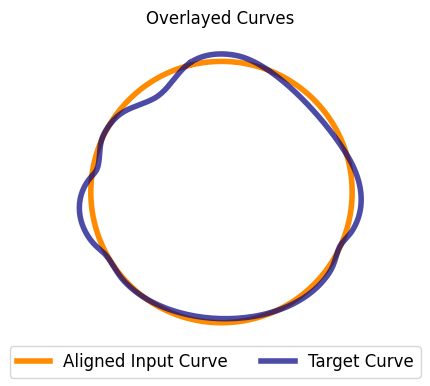

In [47]:
plt.figure(figsize=(8,8))
visualizer(best_sol, edges, fixed_joints, motor, ax=plt.gca())

traced_curve = solver(best_sol, edges, fixed_joints, motor)[target_idx]
curve_engine.visualize_comparison(
    traced_curve,
    target_curves[3]
)

print(f'Distance: {results.F[best_idx,0]:.4f}, Material: {results.F[best_idx,1]:.4f}')

You can use this population to make a submission:

In [48]:
from LINKS.CP import make_empty_submission, evaluate_submission

submission = make_empty_submission()

# add out population to submission
if all_results: # Check if all_results is not empty
    for problem_key, mechanisms in all_results.items():
        # Ensure the problem key is in the correct format (e.g., 'Problem 1')
        if problem_key in submission:
            for mech in mechanisms:
                # Check if the mechanism dictionary has the required keys before appending
                if all(key in mech for key in ['x0', 'edges', 'fixed_joints', 'motor', 'target_joint']):
                    submission[problem_key].append(mech)
                else:
                    print(f"Skipping mechanism due to missing keys in {problem_key}: {mech}")
        else:
            print(f"Skipping problem key not found in submission structure: {problem_key}")

In [49]:
evaluate_submission(submission)

{'Overall Score': 0.7373356286458316,
 'Score Breakdown': {'Problem 1': 0.0,
  'Problem 2': 0.0,
  'Problem 3': 0.0,
  'Problem 4': 4.424013771874989,
  'Problem 5': 0.0,
  'Problem 6': 0.0}}

A small improvement. But this is just to give you an idea of what you can do when mixing optimization methods.

Now you should have a good idea of how to use the tools we have provided to you. Think about how you can improve each aspect of the optimization to achieve a higher score in you final submission. You are allowed also submit your teams best solutions to the leaderboard which we will announce soon and see how well you are doing compared other teams.

A few hints and ideas:
- Why not do some preprocessing to random mechanisms before running GA?
- Can you use the gradients of both functions in gradient based optimization?
- Can you cycle through multiple optimization runs?
- Can you mix different kinds of GA? We showed how GA can be used for a single mechanism skeleton and how it can be used to also create the mechanisms?
- Can you modify the GA mutations and cross-over?
- Is there a more efficient representation of mechanisms we can use?
- Are there smarter gradient-based optimization methods?

## Loop through all six target curves
Modify the code to loop through all 6 target curves, perform the optimization process for each, and generate a submission file containing the results for each problem (Problem 1 to Problem 6).

In [66]:
def optimize_for_target_curve(target_curve, N=7):
    """
    Performs the optimization process for a given target curve using GA followed by gradient descent and another GA run.

    Args:
        target_curve (np.ndarray): The target curve as a numpy array of points.
        N (int): The number of nodes in the mechanism.

    Returns:
        list: A list of optimized mechanisms in dictionary representation.
    """
    # 1. Instantiate the mechanism_synthesis_optimization problem
    problem = mechanism_synthesis_optimization(target_curve, N=N)

    # 2. Generate an initial population of random mechanisms
    randomizer = MechanismRandomizer(min_size=N, max_size=N, device='cpu')
    mechanisms = [randomizer(n=N) for _ in trange(100, desc="Generating initial population")]

    # 3. Convert the initial population to the 1D representation
    initial_population_1D = [problem.convert_mech_to_1D(**mech) for mech in mechanisms]

    # 4. Define the sample_from_random sampling class
    class sample_from_random(Sampling):
        def _do(self, problem, n_samples, **kwargs):
            return np.array([initial_population_1D[i % len(initial_population_1D)] for i in range(n_samples)])

    # 5. Initialize the first NSGA2 algorithm (initial GA)
    algorithm_initial_ga = NSGA2(pop_size=100,
                                 sampling=sample_from_random(),
                                 mating=MixedVariableMating(eliminate_duplicates=MixedVariableDuplicateElimination()),
                                 mutation=PolynomialMutation(prob=0.5),
                                 eliminate_duplicates=MixedVariableDuplicateElimination())

    # 6. Run the first minimize function (initial GA)
    results_initial_ga = minimize(problem,
                                  algorithm_initial_ga,
                                  ('n_gen', 100),
                                  verbose=False, # Set to False to reduce output during the loop
                                  save_history=True,
                                  seed=0
                                 )

    # 7. Extract the optimized solutions from the initial GA and convert to mechanism representation
    x0s_ga = []
    edges_ga = []
    fixed_joints_ga = []
    motors_ga = []
    target_idxs_ga = []

    if results_initial_ga.X is not None:
        if not isinstance(results_initial_ga.X, dict):
            for i in range(results_initial_ga.X.shape[0]):
                x0_member, edges_member, fixed_joints_member, motor_member, target_idx_member = problem.convert_1D_to_mech(results_initial_ga.X[i])
                x0s_ga.append(x0_member)
                edges_ga.append(edges_member)
                fixed_joints_ga.append(fixed_joints_member)
                motors_ga.append(motor_member)
                target_idxs_ga.append(target_idx_member)
        else:
            x0_member, edges_member, fixed_joints_member, motor_member, target_idx_member = problem.convert_1D_to_mech(results_initial_ga.X)
            x0s_ga.append(x0_member)
            edges_ga.append(edges_member)
            fixed_joints_ga.append(fixed_joints_member)
            motors_ga.append(motor_member)
            target_idxs_ga.append(target_idx_member)

    # Convert target_idxs_ga to a numpy array of integers
    target_idxs_ga_int = np.array(target_idxs_ga, dtype=int)


    # 8. Perform gradient-based optimization for distance
    x_d = x0s_ga.copy()
    step_size = 4e-4
    n_steps = 1000
    done_optimizing_d = np.zeros(len(x_d), dtype=bool)
    x_last_d = x_d.copy()

    for step in trange(n_steps, desc="Gradient descent (distance)"):
        distances, materials, distance_grads, material_grads = differentiable_optimization_tools(
            x_d, edges_ga, fixed_joints_ga, motors_ga, target_curve, target_idxs_ga_int
        )

        valids = np.where(np.logical_and(distances <= 0.75, materials <= 10.0))[0]
        invalids = np.where(~np.logical_and(distances <= 0.75, materials <= 10.0))[0]

        for i in invalids:
            done_optimizing_d[i] = True
            x_d[i] = x_last_d[i]

        x_last_d = x_d.copy()

        for i in valids:
            if done_optimizing_d[i]:
                continue
            x_d[i] = x_d[i] - step_size * distance_grads[i]

        if np.all(done_optimizing_d):
            break

    # 9. Perform gradient-based optimization for material
    x_m = x0s_ga.copy()
    done_optimizing_m = np.zeros(len(x_m), dtype=bool)
    x_last_m = x_m.copy()

    for step in trange(n_steps, desc="Gradient descent (material)"):
        distances, materials, distance_grads, material_grads = differentiable_optimization_tools(
            x_m, edges_ga, fixed_joints_ga, motors_ga, target_curve, target_idxs_ga_int
        )

        valids = np.where(np.logical_and(distances <= 0.75, materials <= 10.0))[0]
        invalids = np.where(~np.logical_and(distances <= 0.75, materials <= 10.0))[0]

        for i in invalids:
            done_optimizing_m[i] = True
            x_m[i] = x_last_m[i]

        x_last_m = x_m.copy()

        for i in valids:
            if done_optimizing_m[i]:
                continue
            x_m[i] = x_m[i] - step_size * material_grads[i]

        if np.all(done_optimizing_m):
            break


    # 10. Combine the initial GA solutions with gradient-optimized solutions and convert to 1D representation
    combined_initial_population_1D = []
    for i in range(len(x0s_ga)):
        # Original GA solution
        combined_initial_population_1D.append(problem.convert_mech_to_1D(
            x0=x0s_ga[i], edges=edges_ga[i], fixed_joints=fixed_joints_ga[i], motor=motors_ga[i], target_idx=target_idxs_ga_int[i]
        ))
        # Distance optimized solution
        combined_initial_population_1D.append(problem.convert_mech_to_1D(
            x0=x_d[i], edges=edges_ga[i], fixed_joints=fixed_joints_ga[i], motor=motors_ga[i], target_idx=target_idxs_ga_int[i]
        ))
        # Material optimized solution
        combined_initial_population_1D.append(problem.convert_mech_to_1D(
            x0=x_m[i], edges=edges_ga[i], fixed_joints=fixed_joints_ga[i], motor=motors_ga[i], target_idx=target_idxs_ga_int[i]
        ))


    # 11. Define a custom Sampling class to use the combined initial population for the second GA
    class CombinedPopulationSampling(Sampling):
        def __init__(self, population):
            super().__init__()
            self.population = population

        def _do(self, problem, n_samples, **kwargs):
            return np.array([self.population[i % len(self.population)] for i in range(n_samples)]) # Sample with replacement if n_samples > population size


    # 12. Initialize the second NSGA2 algorithm (on combined population)
    algorithm_combined_ga = NSGA2(pop_size=len(combined_initial_population_1D), # Use the size of the combined population
                                  sampling=CombinedPopulationSampling(combined_initial_population_1D), # Use the custom sampling class
                                  mating=MixedVariableMating(eliminate_duplicates=MixedVariableDuplicateElimination()),
                                  mutation=PolynomialMutation(prob=0.5),
                                  eliminate_duplicates=MixedVariableDuplicateElimination())

    # 13. Run the second minimize function (on combined population)
    results_combined_ga = minimize(problem,
                                   algorithm_combined_ga,
                                   ('n_gen', 100), # You can adjust the number of generations for the second GA
                                   verbose=False,
                                   save_history=True,
                                   seed=0
                                  )

    # 14. Extract the optimized solutions from the second GA and convert to mechanism representation
    final_optimized_mechanisms = []
    if results_combined_ga.X is not None:
        if not isinstance(results_combined_ga.X, dict):
            for i in range(results_combined_ga.X.shape[0]):
                x0_member, edges_member, fixed_joints_member, motor_member, target_idx_member = problem.convert_1D_to_mech(results_combined_ga.X[i])
                final_optimized_mechanisms.append({
                    'x0': x0_member,
                    'edges': edges_member,
                    'fixed_joints': fixed_joints_member,
                    'motor': motor_member,
                    'target_joint': target_idx_member
                })
        else:
            x0_member, edges_member, fixed_joints_member, motor_member, target_idx_member = problem.convert_1D_to_mech(results_combined_ga.X)
            final_optimized_mechanisms.append({
                'x0': x0_member,
                'edges': edges_member,
                'fixed_joints': fixed_joints_member,
                'motor': motor_member,
                'target_joint': target_idx_member
            })


    # 15. Return the final optimized mechanisms
    return final_optimized_mechanisms

In [58]:
import matplotlib.pyplot as plt
target_curves = np.load('/content/target_curves.npy')

In [67]:
all_results = {}

for i in range(6):
    print(f"Optimizing for target curve {i+1}...")
    optimized_mechanisms = optimize_for_target_curve(target_curves[i])
    all_results[f'Problem {i+1}'] = optimized_mechanisms

print("Optimization for all target curves complete.")

Optimizing for target curve 1...


Generating initial population:   0%|          | 0/100 [00:00<?, ?it/s]

Gradient descent (distance):   0%|          | 0/1000 [00:00<?, ?it/s]

TypeError: Indexer must have integer or boolean type, got indexer with type float32 at position 1, indexer value Traced<ShapedArray(float32[0])>with<DynamicJaxprTrace>

In [64]:
from LINKS.CP import make_empty_submission, evaluate_submission

submission = make_empty_submission()

# add out population to submission
if all_results: # Check if all_results is not empty
    for problem_key, mechanisms in all_results.items():
        # Ensure the problem key is in the correct format (e.g., 'Problem 1')
        if problem_key in submission:
            for mech in mechanisms:
                # Check if the mechanism dictionary has the required keys before appending
                if all(key in mech for key in ['x0', 'edges', 'fixed_joints', 'motor', 'target_joint']):
                    submission[problem_key].append(mech)
                else:
                    print(f"Skipping mechanism due to missing keys in {problem_key}: {mech}")
        else:
            print(f"Skipping problem key not found in submission structure: {problem_key}")

In [65]:
evaluate_submission(submission)

{'Overall Score': 2.846366987306465,
 'Score Breakdown': {'Problem 1': 4.623967292761707,
  'Problem 2': 1.9900143557859593,
  'Problem 3': 2.9015007001206214,
  'Problem 4': 3.38467146102073,
  'Problem 5': 2.616931542400849,
  'Problem 6': 1.5611165717489257}}

In [57]:
np.save('my_full_submission.npy', submission) # This will save your submission in the current directory